### Chapter 4.2 - 강남역 맛집 리뷰 분석

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns 
import warnings 
warnings.filterwarnings('ignore')

import json 
import requests 

### Step 1. Crawling the Kakao map reviews 

In [2]:
from selenium import webdriver
from bs4 import BeautifulSoup
import re
import time

In [3]:
# 크롤링할 사이트 주소를 정의
source_url = "https://map.kakao.com/"

# windows 크롬 드라이버 사용
driver = webdriver.Chrome(executable_path= 'chrom_driver/chromedriver.exe')

# 카카오 지도에 접속
driver.get(source_url)

# 검색창에 검색어를 입력
searchbox = driver.find_element_by_xpath("//input[@id='search.keyword.query']")
searchbox.send_keys("강남역 고기집")

# 검색버튼을 눌러서 결과를 가져옵니다
searchbutton = driver.find_element_by_xpath("//button[@id='search.keyword.submit']")
driver.execute_script("arguments[0].click();", searchbutton)

# 검색 결과를 가져올 시간을 기다립니다
time.sleep(2)

# 검색 결과의 페이지 소스를 가져옵니다
html = driver.page_source

# BeautifulSoup을 이용하여 html 정보를 파싱합니다
soup = BeautifulSoup(html, "html.parser")
moreviews = soup.find_all(name="a", attrs={"class":"moreview"})

# a태그의 href 속성을 리스트로 추출하여, 크롤링 할 페이지 리스트를 생성
page_urls = []
for moreview in moreviews:
    page_url = moreview.get("href")
    print(page_url)
    page_urls.append(page_url)

# 크롤링에 사용한 브라우저를 종료
driver.close()

https://place.map.kakao.com/85570955
https://place.map.kakao.com/1503746075
https://place.map.kakao.com/95713992
https://place.map.kakao.com/741391811
https://place.map.kakao.com/2011092566
https://place.map.kakao.com/2062959414
https://place.map.kakao.com/1648266796
https://place.map.kakao.com/13573220
https://place.map.kakao.com/168079537
https://place.map.kakao.com/263830255
https://place.map.kakao.com/1780387311
https://place.map.kakao.com/27238067
https://place.map.kakao.com/26431943
https://place.map.kakao.com/1907052666
https://place.map.kakao.com/2021432189
https://place.map.kakao.com/1052874675


In [4]:
columns = ['score', 'review']
df = pd.DataFrame(columns=columns)

driver = webdriver.Chrome(executable_path= 'chrom_driver/chromedriver.exe') 

for page_url in page_urls:
    
    # 상세보기 페이지에 접속합니다
    driver.get(page_url)
    time.sleep(2)
    
    # 첫 페이지 리뷰를 크롤링합니다
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    contents_div = soup.find(name="div", attrs={"class":"evaluation_review"})
    
    # 별점을 가져옵니다.
    rates = contents_div.find_all(name="em", attrs={"class":"num_rate"})
    
    # 리뷰를 가져옵니다.
    reviews = contents_div.find_all(name="p", attrs={"class":"txt_comment"})
    
    for rate, review in zip(rates, reviews):
        row = [rate.text[0], review.find(name="span").text]
        series = pd.Series(row, index=df.columns)
        df = df.append(series, ignore_index=True)
    
    # 2-5페이지의 리뷰를 크롤링합니다
    for button_num in range(2, 6):
        # 오류가 나는 경우(리뷰 페이지가 없는 경우), 수행하지 않습니다.
        try:
            another_reviews = driver.find_element_by_xpath("//a[@data-page='" + str(button_num) + "']")
            another_reviews.click()
            time.sleep(2)
            
            # 페이지 리뷰를 크롤링합니다
            html = driver.page_source
            soup = BeautifulSoup(html, 'html.parser')
            contents_div = soup.find(name="div", attrs={"class":"evaluation_review"})

            # 별점을 가져옵니다.
            rates = contents_div.find_all(name="em", attrs={"class":"num_rate"})

            # 리뷰를 가져옵니다.
            reviews = contents_div.find_all(name="p", attrs={"class":"txt_comment"})

            for rate, review in zip(rates, reviews):
                row = [rate.text[0], review.find(name="span").text]
                series = pd.Series(row, index=df.columns)
                df = df.append(series, ignore_index=True)
        except:
            break    
driver.close()

In [5]:
# 4점 이상의 리뷰는 긍정(1) 리뷰, 3점 이하의 리뷰는 부정(0) 리뷰로 평가
df['y'] = df['score'].apply(lambda x: 1 if int(x) > 3 else 0)

print(df.shape)
df.head()

(372, 3)


,score,review,y
0,5,新鮮でおいしいです。,1
1,4,녹는다 녹아,1
2,4,,1
3,5,흠잡을곳 없는 반찬이 정갈합니다,1
4,5,코로나 땜에 걱정했는데 방역수칙도 잘 지키시고 살치실이랑 등심 부드러워서 너무 좋아...,1


In [6]:
#df.to_csv("output/review_data.csv", index=False)

### Step 2. TF-IDF를 이용한 핵심어 추출

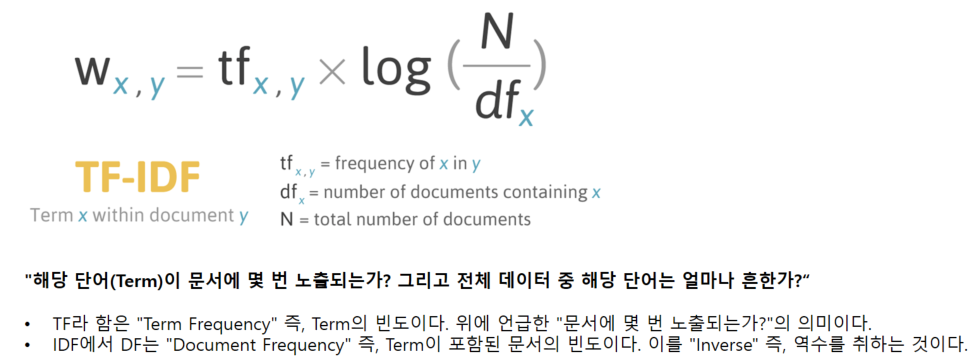

In [7]:
from IPython.display import Image
Image('img/tf-idf.PNG')

In [8]:
import re

# 한글 이외의 문자는 전부 제거
def text_cleaning(text):    
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')   # 한글의 정규표현식으로 한글만 추출   
    result = hangul.sub('', text)
    return result

In [9]:
df['ko_text'] = df['review'].apply(lambda x: text_cleaning(x))
del df['review']
df = df[df['ko_text'].str.len() > 0] # 한 글자 이상의 텍스트를 가지고 있는 데이터만 추출

print(df.shape)
df.head()

(301, 3)


,score,y,ko_text
1,4,1,녹는다 녹아
3,5,1,흠잡을곳 없는 반찬이 정갈합니다
4,5,1,코로나 땜에 걱정했는데 방역수칙도 잘 지키시고 살치실이랑 등심 부드러워서 너무 좋아...
5,5,1,살치살 미쳤네요 대박입니다 퀄리티 굳이에요
6,5,1,최고


In [10]:
## 형태소 추출 
from konlpy.tag import Okt

def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    pos = ['{}/{}'.format(word,tag) for word, tag in pos]
    return pos

result = get_pos(df['ko_text'].values[:5])
print(result)

ImportError: DLL load failed while importing _jpype: DLL 초기화 루틴을 실행할 수 없습니다.